## FBPINN with uniform domain decomposition

In the following, we first trained a model on the pde_phi_sin problem with uniform domain decomposition on the interval

```
training:
  steps: 50000
  lr: 0.001
  n_sub: 10
  overlap: 2
  n_points_per_subdomain: 200

mlp:
  in_size: 1
  out_size: 1
  width_size: 16
  depth: 2
  activation: "tanh" 
```

In [ ]:
import os
import sys
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Optional: Add project root to PYTHONPATH if needed
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from utils.data_utils import generate_subdomain, generate_collocation_points
from utils.window_function import my_window_func
from model.fbpinn_model import FBPINN
from train.trainer_fbpinn import train_fbpinn
import physics.pde_phi_sin as pde_module

u_exact = pde_module.u_exact
ansatz = pde_module.ansatz
pde_residual_loss = pde_module.pde_residual_loss
domain = pde_module.DOMAIN  #  (0, 8)

# Training hyperparameters
steps = 50000
lr = 1e-3
n_sub = 5
overlap = 2.0
n_points_per_subdomain = 200
#ckpt_every = 2000
#save_dir = "outputs/demo_fbpinn"

mlp_config = {
    "in_size": 1,
    "out_size": 1,
    "width_size": 4,
    "depth": 2,
    "activation": jax.nn.tanh,
}

domain = pde_module.DOMAIN


In [8]:
# generate uniform subdomains, n_sub = 5, overlap = 2

subdomains_list = generate_subdomain(domain=domain,n_sub=n_sub,overlap=overlap)
print(subdomains_list)

[(-0.9999999403953552, 2.5999999046325684), (0.6000001430511475, 4.199999809265137), (2.200000047683716, 5.800000190734863), (3.799999475479126, 7.399999618530273), (5.399999618530273, 9.0)]


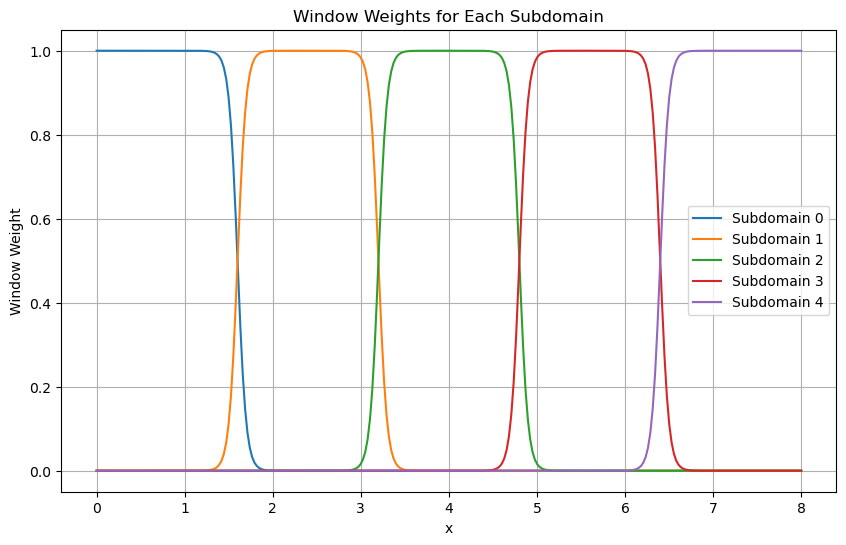

In [9]:
# illustration of window function
x_test = jnp.linspace(0, 8, 300)
window_weights_1 = my_window_func(subdomains_list, n_sub, x_test, tol=1e-8)
# plot
plt.figure(figsize=(10, 6))
for i in range(window_weights_1.shape[1]):
    plt.plot(x_test, window_weights_1[:, i], label=f"Subdomain {i}")

plt.xlabel('x')
plt.ylabel('Window Weight')
plt.legend()
plt.title('Window Weights for Each Subdomain')
plt.grid(True)
plt.show()

In [10]:
key = jax.random.PRNGKey(42)
model_1 = FBPINN(
    key=key,
    num_subdomains=n_sub,
    ansatz=ansatz,
    subdomains=subdomains_list,  
    mlp_config=mlp_config
)

In [11]:
subdomain_collocation_points_1, global_collocation_points_1 = generate_collocation_points(
domain=domain,
subdomains_list=subdomains_list,
n_points_per_subdomain=n_points_per_subdomain,
seed=0
)

In [ ]:
# test
x_test = jnp.linspace(domain[0], domain[1], 300)
# train
model_1, train_loss_1, (test_steps, test_l1_1) = train_fbpinn(
    model=model_1,
    subdomain_collocation_points=subdomain_collocation_points_1,
    steps=steps,
    lr=lr,
    x_test=x_test,
    save_dir=None,
    pde_residual_loss=pde_residual_loss,
    u_exact=u_exact
)

FBPINN:   0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
# Plot
u_pred_1 = jax.vmap(model_1)(x_test)
u_true = u_exact(x_test)

In [ ]:
def plot_fbpinn_summary(x_test, u_true, u_pred,
                                  train_loss, test_steps, test_l1,
                                  model):
    """Display all core visualizations in one figure (Jupyter-friendly)."""

    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    axs = axs.flatten()

    # 1. Prediction vs Exact
    axs[0].plot(x_test, u_pred, label="Predicted")
    axs[0].plot(x_test, u_true, "--", label="Exact")
    axs[0].set_title("Prediction vs Exact")
    axs[0].legend()
    axs[0].grid(True)

    # 2. Training loss
    axs[1].plot(train_loss, label="Train Loss")
    axs[1].set_title("Training Loss (Log Scale)")
    axs[1].set_yscale("log")
    axs[1].legend()
    axs[1].grid(True)

    # 3. L1 error curve
    axs[2].plot(test_steps, test_l1, label="L1 Error")
    axs[2].set_title("Test L1 Error Curve")
    axs[2].set_yscale("log")
    axs[2].set_xlabel("Step")
    axs[2].set_ylabel("L1")
    axs[2].legend()
    axs[2].grid(True)

    # 4. Subdomain partials
    n_sub = len(model.subnets)
    for i in range(n_sub):
        partial_solution_i = jax.vmap(lambda x: model.subdomain_pred(i, x))(x_test).squeeze()
        window_i = model.subdomain_window(i, x_test)
        weighted = model.ansatz(x_test, window_i * partial_solution_i)
        axs[3].plot(x_test, weighted, label=f"Subdomain {i}", alpha=0.6)
    axs[3].plot(x_test, u_true, "--", color="black", label="Exact", linewidth=2)
    axs[3].set_title("Subdomain Partial Predictions")
    axs[3].legend(fontsize=8, ncol=2)
    axs[3].grid(True)

    plt.tight_layout()
    plt.show()


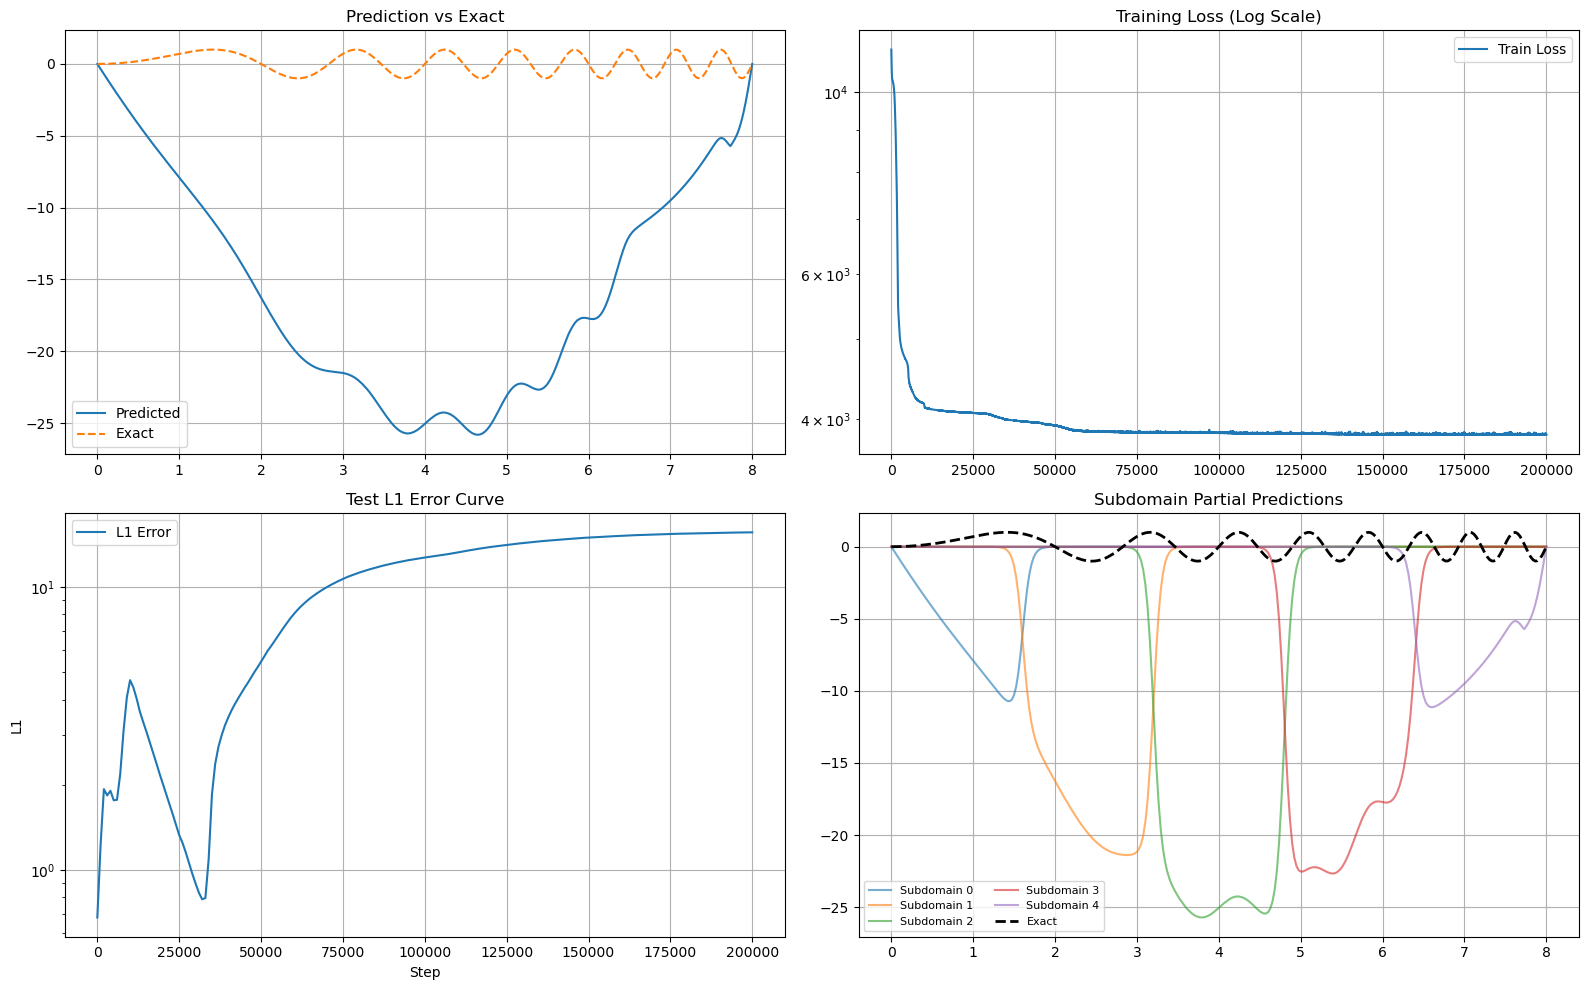

In [ ]:
plot_fbpinn_summary(
    x_test=x_test,
    u_true=u_true,
    u_pred=u_pred_1,
    train_loss=train_loss_1,
    test_steps=test_steps,
    test_l1=test_l1_1,
    model=model_1
)


## FBPINN with self-defined domain decompostion

Here we define the domain as follows:

In [ ]:
'''subdomains_list_defined = [
    (-1.0, 3.5),   
    (1.0, 5.0),
    (2.0, 6.0),
    (3.5, 6.5),
    (4.5, 7.0),
    (5.5, 7.5),
    (6.0, 8.0),
    (6.5, 8.5),
    (7.0, 9.0),
    (7.5, 9.5),    
]'''

'subdomains_list_defined = [\n    (-1.0, 3.5),   \n    (1.0, 5.0),\n    (2.0, 6.0),\n    (3.5, 6.5),\n    (4.5, 7.0),\n    (5.5, 7.5),\n    (6.0, 8.0),\n    (6.5, 8.5),\n    (7.0, 9.0),\n    (7.5, 9.5),    \n]'

In [ ]:
subdomains_list_defined = [
    (-1.0, 4.0),   
    (2.0, 6.0),    
    (4.0, 7.0),   
    (6.0, 8.0),    
    (7.0, 9.0),    
]
subdomain_collocation_points_2, global_collocation_points_2 = generate_collocation_points(
domain=domain,
subdomains_list=subdomains_list_defined,
n_points_per_subdomain=n_points_per_subdomain,
seed=0
)

Subdomain [-1.00, 4.00]: 505 points
Subdomain [2.00, 6.00]: 519 points
Subdomain [4.00, 7.00]: 384 points
Subdomain [6.00, 8.00]: 234 points
Subdomain [7.00, 9.00]: 111 points


In [ ]:
key = jax.random.PRNGKey(42)
model_2 = FBPINN(
    key=key,
    num_subdomains=n_sub,
    ansatz=ansatz,
    subdomains=subdomains_list_defined,  
    mlp_config=mlp_config
)

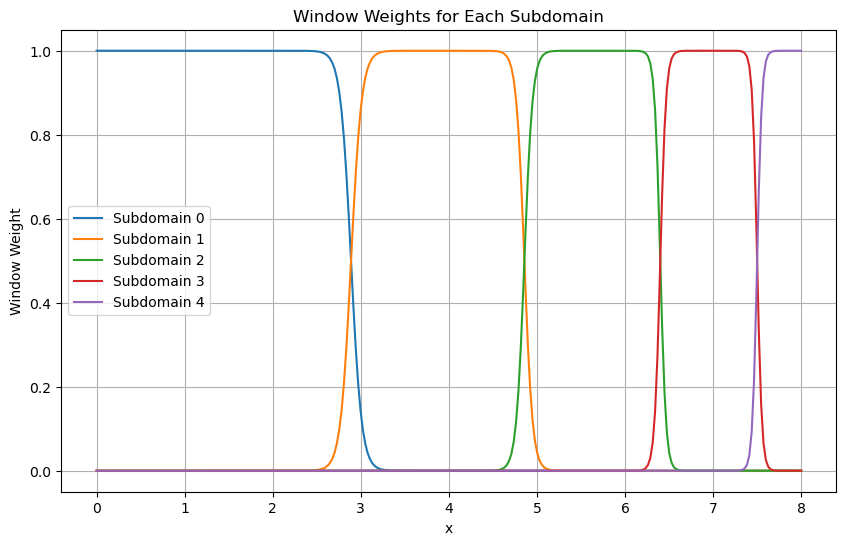

In [ ]:
# illustration of window function
x_test = jnp.linspace(0, 8, 300)
window_weights = my_window_func(subdomains_list_defined, n_sub, x_test, tol=1e-8)
# plot
plt.figure(figsize=(10, 6))
for i in range(window_weights.shape[1]):
    plt.plot(x_test, window_weights[:, i], label=f"Subdomain {i}")

plt.xlabel('x')
plt.ylabel('Window Weight')
plt.legend()
plt.title('Window Weights for Each Subdomain')
plt.grid(True)
plt.show()

In [ ]:
# test
x_test = jnp.linspace(domain[0], domain[1], 300)
# train
model_2, train_loss_2, (test_steps, test_l1_2) = train_fbpinn(
    model=model_2,
    subdomain_collocation_points=subdomain_collocation_points_2,
    steps=steps,
    lr=lr,
    x_test=x_test,
    save_dir=None,
    pde_residual_loss=pde_residual_loss,
    u_exact=u_exact
)

[FBPINN] Step=0, Loss=2.173e+04, L1=6.7175e-01
[FBPINN] Step=1000, Loss=1.677e+04, L1=6.1083e-01
[FBPINN] Step=2000, Loss=1.097e+04, L1=1.2456e+00
[FBPINN] Step=3000, Loss=8.972e+03, L1=2.1582e+00
[FBPINN] Step=4000, Loss=4.846e+03, L1=2.3461e+00
[FBPINN] Step=5000, Loss=3.833e+03, L1=2.4019e+00
[FBPINN] Step=6000, Loss=3.540e+03, L1=2.6897e+00
[FBPINN] Step=7000, Loss=3.455e+03, L1=2.8591e+00
[FBPINN] Step=8000, Loss=3.391e+03, L1=3.0205e+00
[FBPINN] Step=9000, Loss=3.345e+03, L1=3.1172e+00
[FBPINN] Step=10000, Loss=3.311e+03, L1=3.1194e+00
[FBPINN] Step=11000, Loss=3.271e+03, L1=2.9373e+00
[FBPINN] Step=12000, Loss=3.242e+03, L1=2.8321e+00
[FBPINN] Step=13000, Loss=3.209e+03, L1=2.7662e+00
[FBPINN] Step=14000, Loss=3.187e+03, L1=3.3195e+00
[FBPINN] Step=15000, Loss=3.171e+03, L1=4.2949e+00
[FBPINN] Step=16000, Loss=1.755e+03, L1=5.0512e+00
[FBPINN] Step=17000, Loss=1.293e+03, L1=5.0422e+00
[FBPINN] Step=18000, Loss=1.133e+03, L1=4.8294e+00
[FBPINN] Step=19000, Loss=1.028e+03, L1=4.52

In [ ]:
# Plot
u_pred_defined = jax.vmap(model_2)(x_test)
u_true = u_exact(x_test)

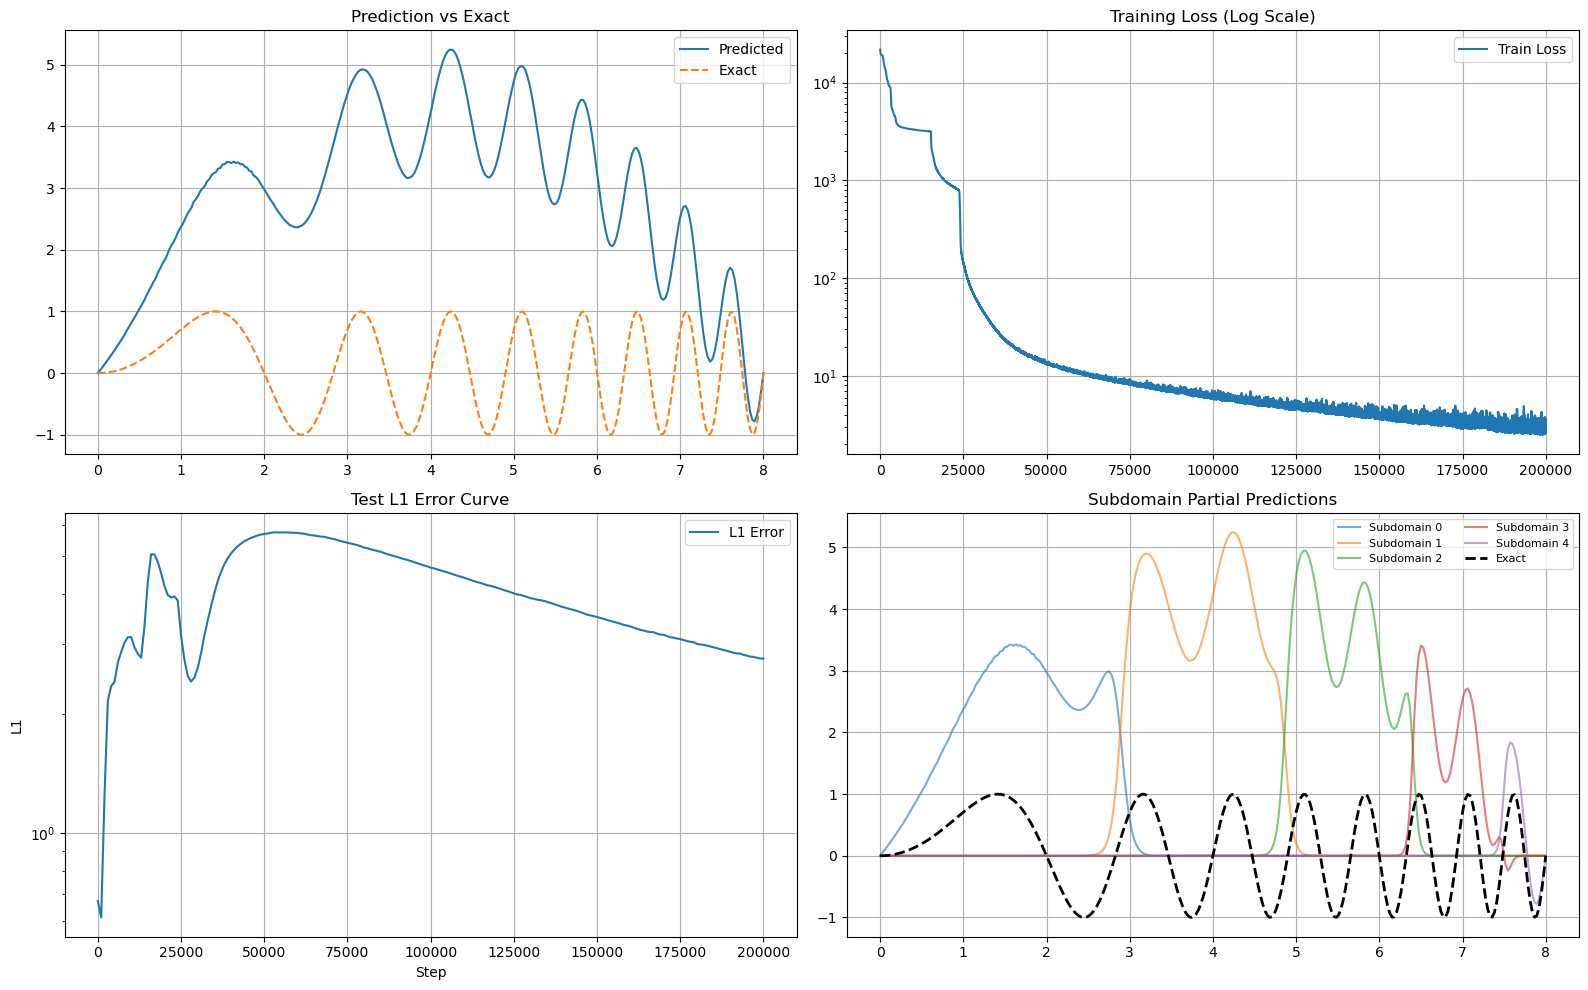

In [ ]:
plot_fbpinn_summary(
    x_test=x_test,
    u_true=u_true,
    u_pred=u_pred_defined,
    train_loss=train_loss_2,
    test_steps=test_steps,
    test_l1=test_l1_2,
    model=model_2
)


## Comparison of self-defined partion of unity and the uniform one:

In [ ]:
def plot_loss_and_l1_comparison(train_loss_1, train_loss_2,
                                test_steps, test_l1_1, test_l1_2,
                                label_1="Uniform", label_2="Self-defined"):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Training Loss
    axs[0].plot(train_loss_2, label=label_2)
    axs[0].plot(train_loss_1, label=label_1)
    axs[0].set_title("Training Loss")
    axs[0].set_yscale("log")
    axs[0].set_xlabel("Step")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid(True)

    # Test L1 Error
    axs[1].plot(test_steps, test_l1_1, label=label_1)
    axs[1].plot(test_steps, test_l1_2, label=label_2)
    axs[1].set_title("Test L1 Error")
    axs[1].set_yscale("log")
    axs[1].set_xlabel("Step")
    axs[1].set_ylabel("L1 Error")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


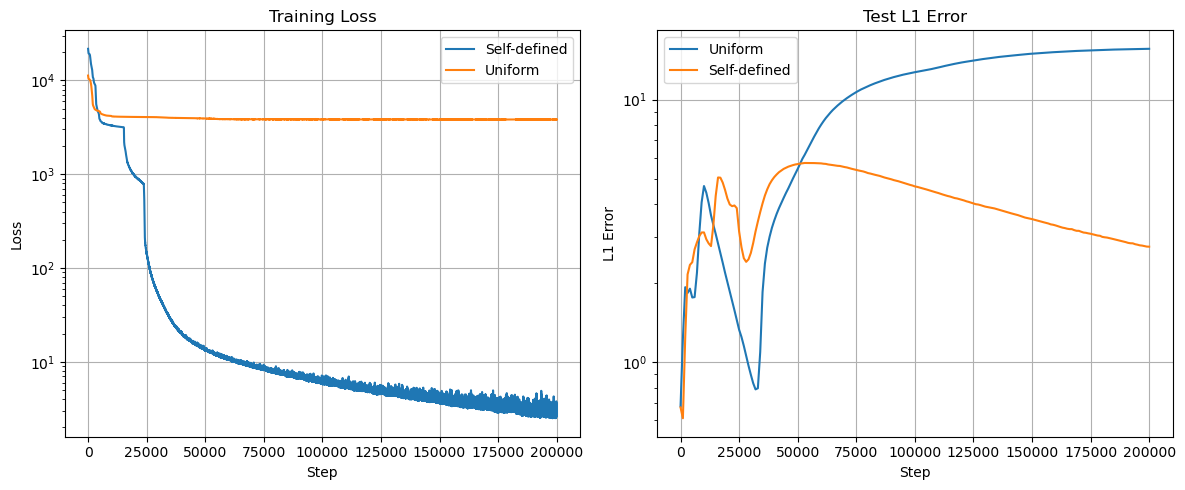

In [ ]:
plot_loss_and_l1_comparison(
    train_loss_1=train_loss_1,
    train_loss_2=train_loss_2,
    test_steps=test_steps,
    test_l1_1=test_l1_1,
    test_l1_2=test_l1_2,
    label_1="Uniform",
    label_2="Self-defined"
)


## Number of partitions = 10, uniform domain decomposition vs. self-defined

In [ ]:
# Training hyperparameters
steps = 50000
lr = 1e-3
n_sub = 10
overlap = 2.0
n_points_per_subdomain = 200
#ckpt_every = 2000
#save_dir = "outputs/demo_fbpinn"

mlp_config = {
    "in_size": 1,
    "out_size": 1,
    "width_size": 16,
    "depth": 2,
    "activation": jax.nn.tanh,
}

domain = pde_module.DOMAIN
# generate uniform subdomains, n_sub = 10, overlap = 2
subdomains_list = generate_subdomain(domain=domain,n_sub=n_sub,overlap=overlap)
print(subdomains_list)


[(-1.0, 1.7999999523162842), (-0.19999992847442627, 2.5999999046325684), (0.6000000238418579, 3.4000000953674316), (1.399999976158142, 4.199999809265137), (2.200000286102295, 5.0), (3.0, 5.800000190734863), (3.799999713897705, 6.599999904632568), (4.599999904632568, 7.400000095367432), (5.400000095367432, 8.199999809265137), (6.199999809265137, 9.0)]


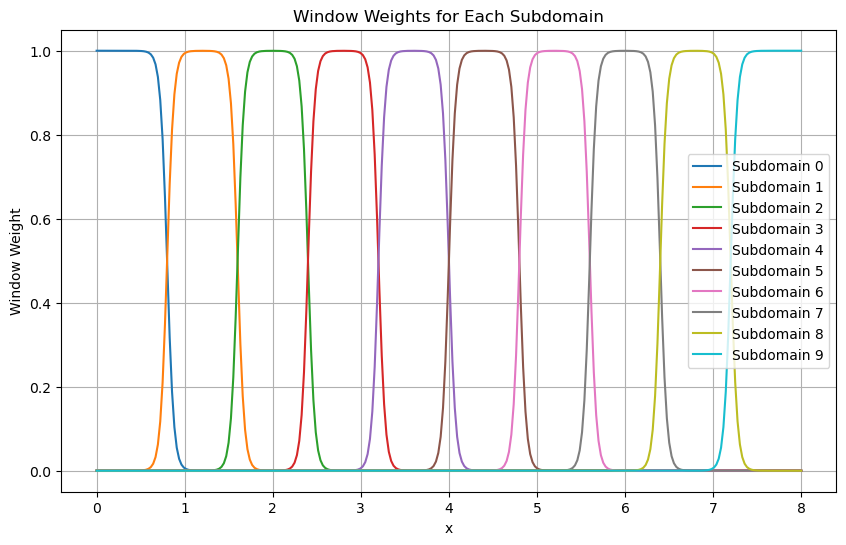

In [ ]:
# illustration of window function
x_test = jnp.linspace(0, 8, 300)
window_weights_3 = my_window_func(subdomains_list, n_sub, x_test, tol=1e-8)
# plot
plt.figure(figsize=(10, 6))
for i in range(window_weights_3.shape[1]):
    plt.plot(x_test, window_weights_3[:, i], label=f"Subdomain {i}")

plt.xlabel('x')
plt.ylabel('Window Weight')
plt.legend()
plt.title('Window Weights for Each Subdomain')
plt.grid(True)
plt.show()

In [ ]:
key = jax.random.PRNGKey(42)
model_3 = FBPINN(
    key=key,
    num_subdomains=n_sub,
    ansatz=ansatz,
    subdomains=subdomains_list,  
    mlp_config=mlp_config
)
subdomain_collocation_points_3, global_collocation_points_3 = generate_collocation_points(
domain=domain,
subdomains_list=subdomains_list,
n_points_per_subdomain=n_points_per_subdomain,
seed=0
)

Subdomain [-1.00, 1.80]: 467 points
Subdomain [-0.20, 2.60]: 686 points
Subdomain [0.60, 3.40]: 753 points
Subdomain [1.40, 4.20]: 707 points
Subdomain [2.20, 5.00]: 707 points
Subdomain [3.00, 5.80]: 683 points
Subdomain [3.80, 6.60]: 678 points
Subdomain [4.60, 7.40]: 675 points
Subdomain [5.40, 8.20]: 623 points
Subdomain [6.20, 9.00]: 410 points


In [ ]:
# test
x_test = jnp.linspace(domain[0], domain[1], 300)
# train
model_3, train_loss_3, (test_steps, test_l1_3) = train_fbpinn(
    model=model_3,
    subdomain_collocation_points=subdomain_collocation_points_3,
    steps=steps,
    lr=lr,
    x_test=x_test,
    save_dir=None,
    pde_residual_loss=pde_residual_loss,
    u_exact=u_exact
)

[FBPINN] Step=0, Loss=2.342e+04, L1=5.9655e-01
[FBPINN] Step=1000, Loss=8.974e+03, L1=1.2045e+00
[FBPINN] Step=2000, Loss=3.118e+03, L1=1.2673e+00
[FBPINN] Step=3000, Loss=1.974e+01, L1=1.3041e+00
[FBPINN] Step=4000, Loss=6.873e+00, L1=1.1438e+00
[FBPINN] Step=5000, Loss=3.342e+00, L1=1.3099e+00
[FBPINN] Step=6000, Loss=1.645e+00, L1=1.2852e+00
[FBPINN] Step=7000, Loss=9.475e-01, L1=1.1860e+00
[FBPINN] Step=8000, Loss=7.651e-01, L1=1.0700e+00
[FBPINN] Step=9000, Loss=5.080e-01, L1=9.5892e-01
[FBPINN] Step=10000, Loss=4.408e-01, L1=8.5812e-01
[FBPINN] Step=11000, Loss=3.530e-01, L1=7.6824e-01
[FBPINN] Step=12000, Loss=2.595e-01, L1=6.9068e-01
[FBPINN] Step=13000, Loss=2.280e-01, L1=6.2173e-01
[FBPINN] Step=14000, Loss=2.746e-01, L1=5.5903e-01
[FBPINN] Step=15000, Loss=2.241e-01, L1=5.0265e-01
[FBPINN] Step=16000, Loss=2.235e-01, L1=4.5221e-01
[FBPINN] Step=17000, Loss=1.599e-01, L1=4.0862e-01
[FBPINN] Step=18000, Loss=1.164e-01, L1=3.6794e-01
[FBPINN] Step=19000, Loss=1.206e-01, L1=3.31

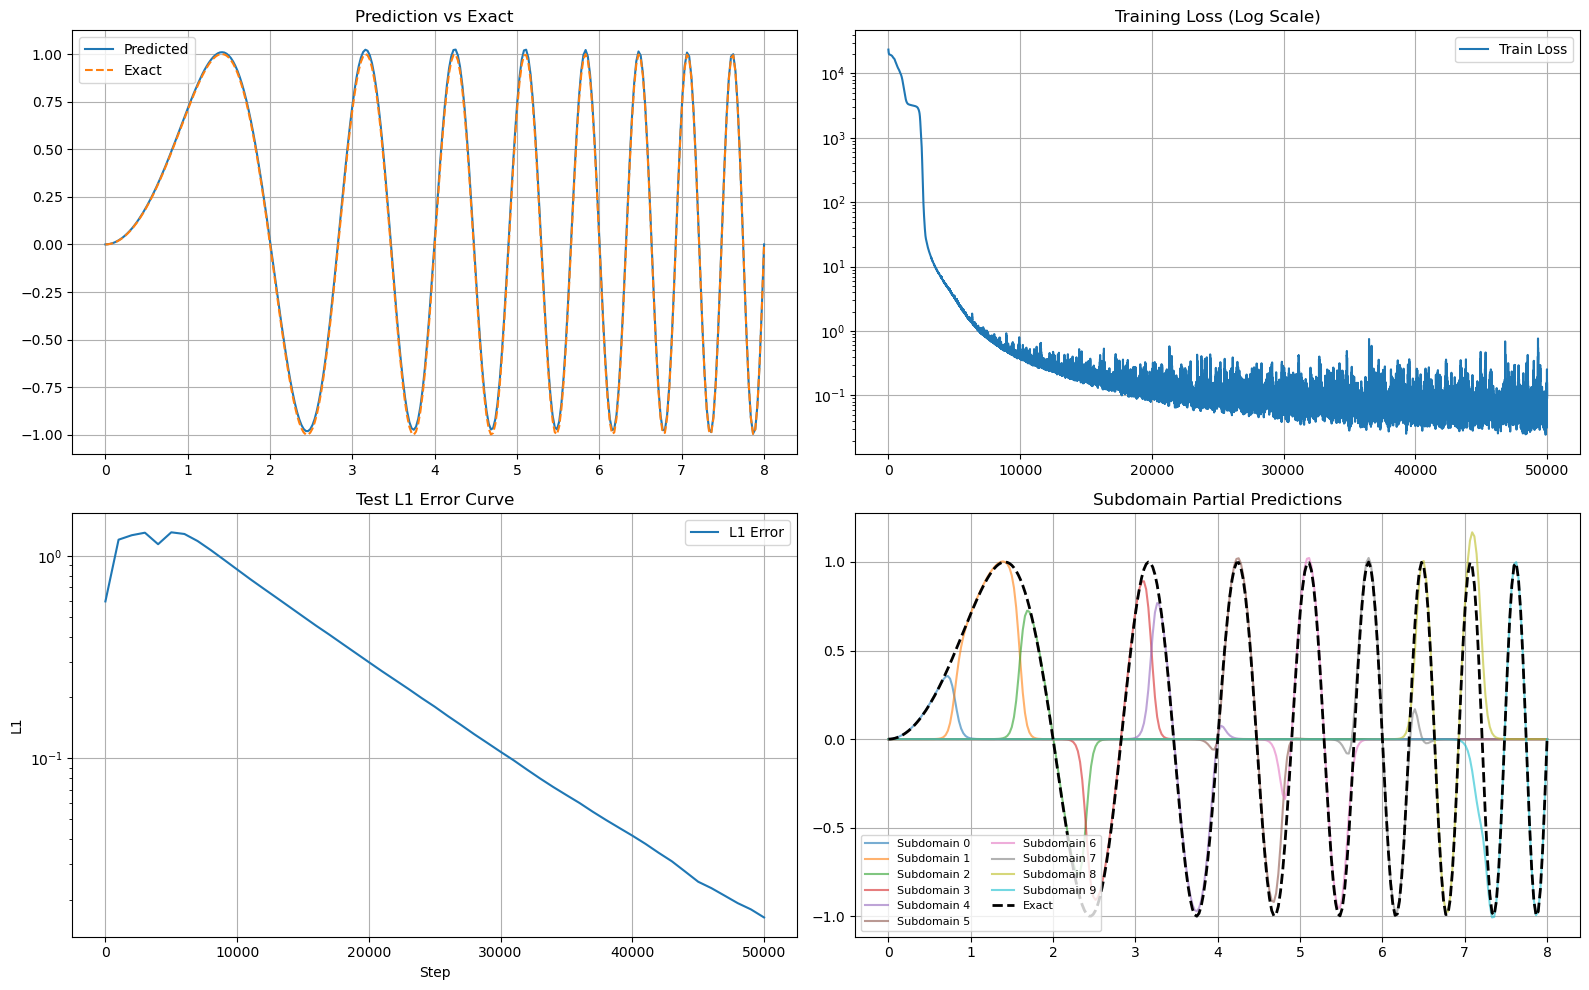

In [ ]:
# Plot
u_pred_3 = jax.vmap(model_3)(x_test)
u_true = u_exact(x_test)
plot_fbpinn_summary(
    x_test=x_test,
    u_true=u_true,
    u_pred=u_pred_3,
    train_loss=train_loss_3,
    test_steps=test_steps,
    test_l1=test_l1_3,
    model=model_3
)


Pre-defined

In [ ]:
subdomains_list_defined_10 = [
    (-1.0, 3.5),   
    (1.0, 5.0),
    (2.0, 6.0),
    (3.5, 6.5),
    (4.5, 7.0),
    (5.5, 7.5),
    (6.0, 8.0),
    (6.5, 8.5),
    (7.0, 9.0),
    (7.5, 9.5),    
]
subdomain_collocation_points_4, global_collocation_points_4 = generate_collocation_points(
domain=domain,
subdomains_list=subdomains_list_defined_10,
n_points_per_subdomain=n_points_per_subdomain,
seed=0
)
key = jax.random.PRNGKey(42)
model_4 = FBPINN(
    key=key,
    num_subdomains=n_sub,
    ansatz=ansatz,
    subdomains=subdomains_list_defined_10,  
    mlp_config=mlp_config
)

Subdomain [-1.00, 3.50]: 914 points
Subdomain [1.00, 5.00]: 1015 points
Subdomain [2.00, 6.00]: 1018 points
Subdomain [3.50, 6.50]: 725 points
Subdomain [4.50, 7.00]: 599 points
Subdomain [5.50, 7.50]: 457 points
Subdomain [6.00, 8.00]: 470 points
Subdomain [6.50, 8.50]: 361 points
Subdomain [7.00, 9.00]: 252 points
Subdomain [7.50, 9.50]: 134 points


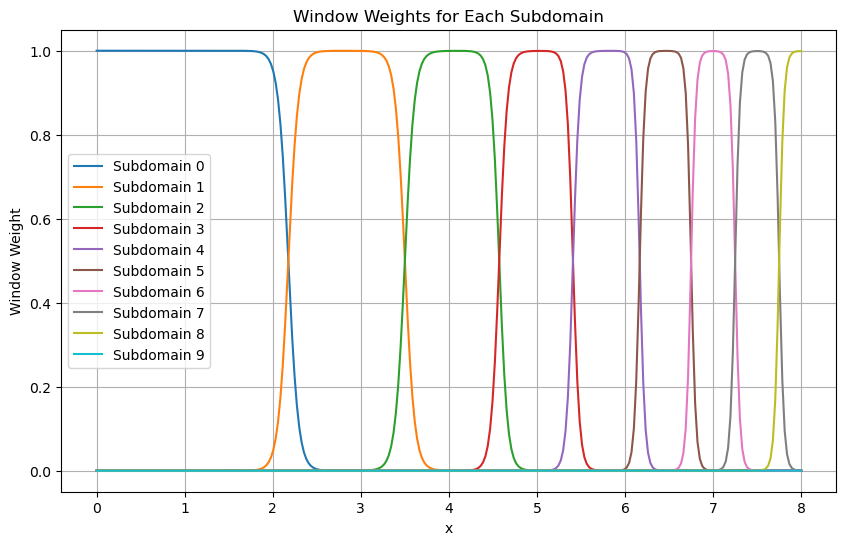

In [ ]:
# illustration of window function
x_test = jnp.linspace(0, 8, 300)
window_weights = my_window_func(subdomains_list_defined_10, n_sub, x_test, tol=1e-8)
# plot
plt.figure(figsize=(10, 6))
for i in range(window_weights.shape[1]):
    plt.plot(x_test, window_weights[:, i], label=f"Subdomain {i}")

plt.xlabel('x')
plt.ylabel('Window Weight')
plt.legend()
plt.title('Window Weights for Each Subdomain')
plt.grid(True)
plt.show()

In [ ]:
# test
x_test = jnp.linspace(domain[0], domain[1], 300)
# train
model_4, train_loss_4, (test_steps, test_l1_4) = train_fbpinn(
    model=model_4,
    subdomain_collocation_points=subdomain_collocation_points_4,
    steps=steps,
    lr=lr,
    x_test=x_test,
    save_dir=None,
    pde_residual_loss=pde_residual_loss,
    u_exact=u_exact
)

[FBPINN] Step=0, Loss=4.962e+04, L1=5.7188e-01
[FBPINN] Step=1000, Loss=6.092e+02, L1=1.0975e+00
[FBPINN] Step=2000, Loss=7.432e+01, L1=5.2398e-01
[FBPINN] Step=3000, Loss=3.872e+01, L1=5.8648e-01
[FBPINN] Step=4000, Loss=1.028e+01, L1=5.8844e-01
[FBPINN] Step=5000, Loss=2.159e+00, L1=9.1245e-01
[FBPINN] Step=6000, Loss=8.174e-01, L1=9.7504e-01
[FBPINN] Step=7000, Loss=5.203e-01, L1=9.2040e-01
[FBPINN] Step=8000, Loss=3.323e-01, L1=8.4268e-01
[FBPINN] Step=9000, Loss=2.959e-01, L1=7.6554e-01
[FBPINN] Step=10000, Loss=2.406e-01, L1=6.9423e-01
[FBPINN] Step=11000, Loss=2.288e-01, L1=6.2914e-01
[FBPINN] Step=12000, Loss=2.065e-01, L1=5.6994e-01
[FBPINN] Step=13000, Loss=1.456e-01, L1=5.1650e-01
[FBPINN] Step=14000, Loss=2.201e-01, L1=4.6832e-01
[FBPINN] Step=15000, Loss=1.394e-01, L1=4.2307e-01
[FBPINN] Step=16000, Loss=1.098e-01, L1=3.8305e-01
[FBPINN] Step=17000, Loss=7.164e-02, L1=3.4574e-01
[FBPINN] Step=18000, Loss=6.677e-02, L1=3.1332e-01
[FBPINN] Step=19000, Loss=1.270e-01, L1=2.82

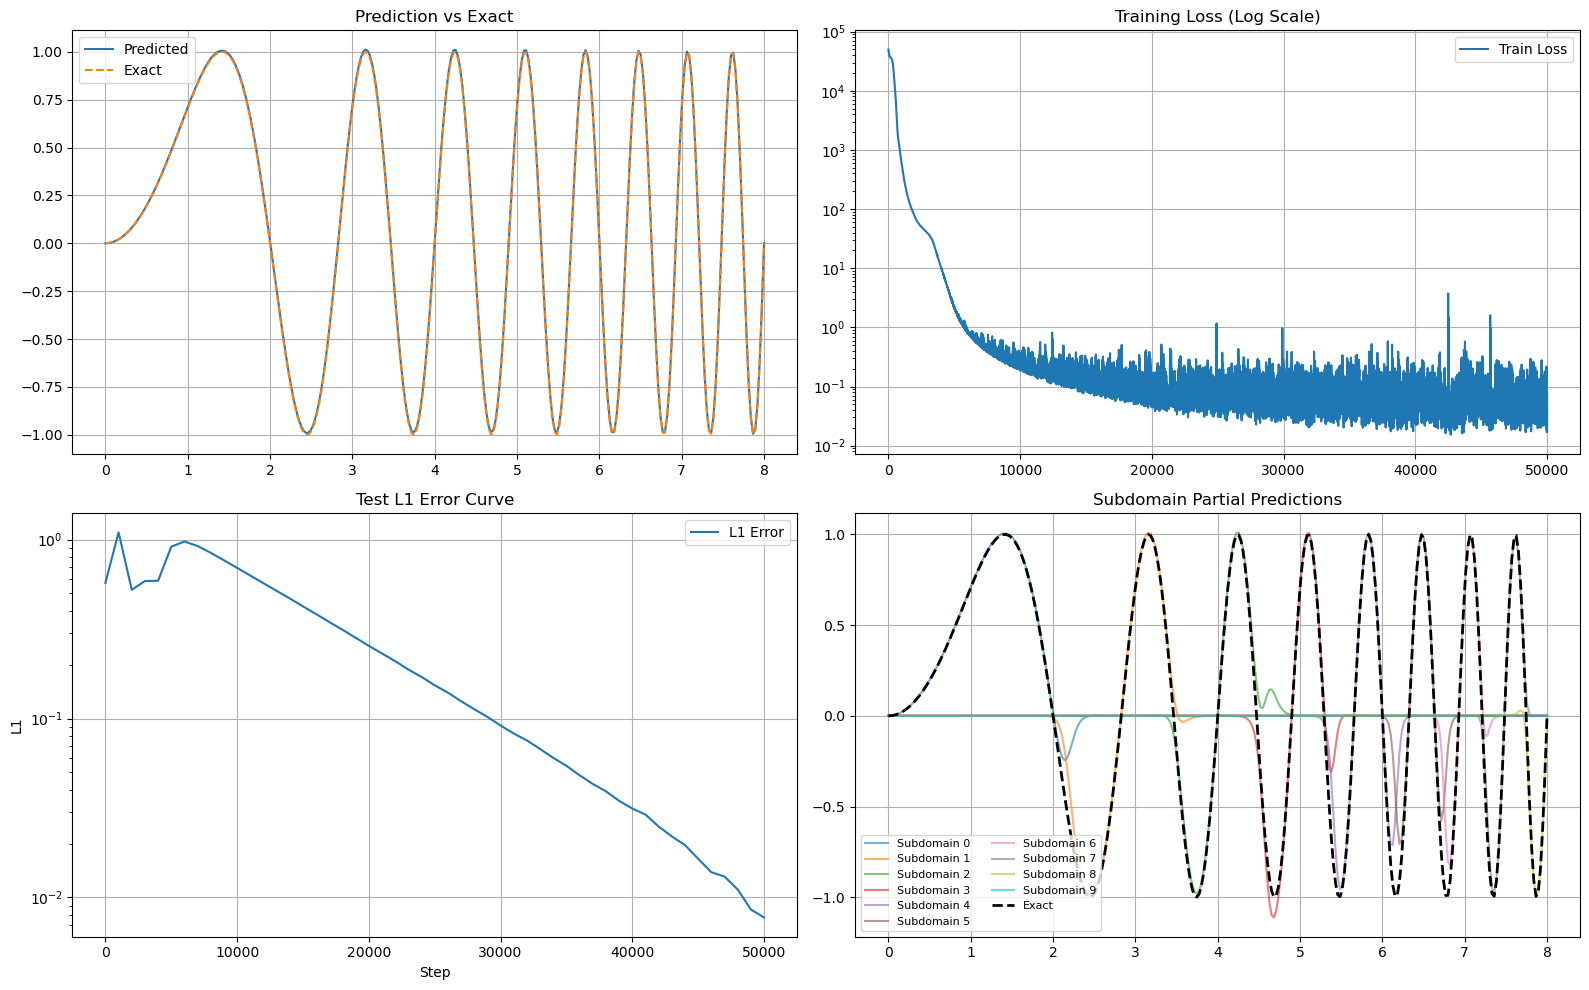

In [ ]:
# Plot
u_pred_4 = jax.vmap(model_4)(x_test)
u_true = u_exact(x_test)
plot_fbpinn_summary(
    x_test=x_test,
    u_true=u_true,
    u_pred=u_pred_4,
    train_loss=train_loss_4,
    test_steps=test_steps,
    test_l1=test_l1_4,
    model=model_4
)


In [ ]:
def plot_loss_and_l1_comparison(train_loss_3, train_loss_4,
                                test_steps, test_l1_3, test_l1_4,
                                label_1="Uniform", label_2="Self-defined"):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Training Loss
    axs[0].plot(train_loss_4, label=label_1)
    axs[0].plot(train_loss_3, label=label_2)
    axs[0].set_title("Training Loss")
    axs[0].set_yscale("log")
    axs[0].set_xlabel("Step")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid(True)

    # Test L1 Error
    axs[1].plot(test_steps, test_l1_3, label=label_1)
    axs[1].plot(test_steps, test_l1_4, label=label_2)
    axs[1].set_title("Test L1 Error")
    axs[1].set_yscale("log")
    axs[1].set_xlabel("Step")
    axs[1].set_ylabel("L1 Error")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


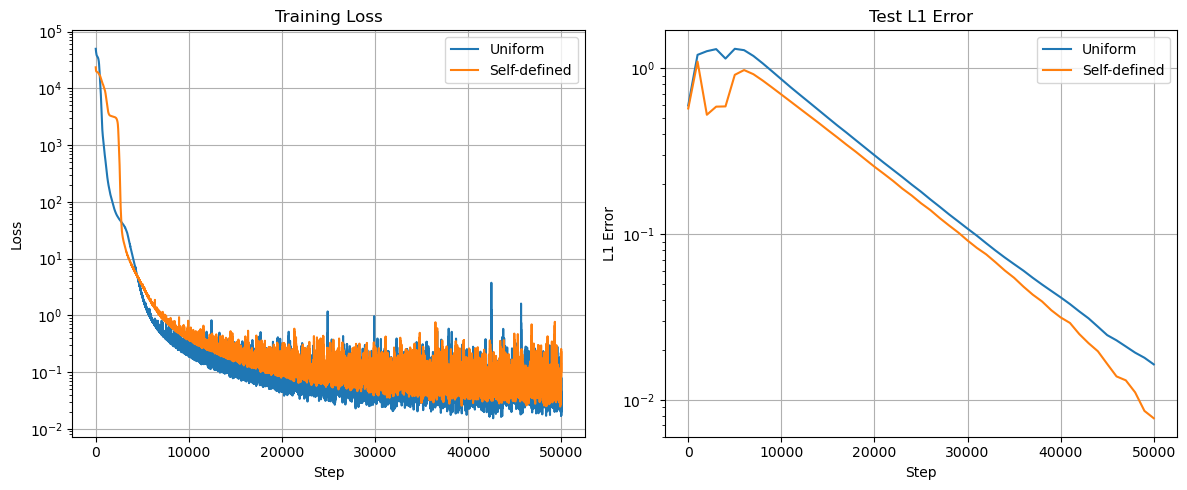

In [ ]:
plot_loss_and_l1_comparison(
    train_loss_3=train_loss_3,
    train_loss_4=train_loss_4,
    test_steps=test_steps,
    test_l1_3=test_l1_3,
    test_l1_4=test_l1_4,
    label_1="Uniform",
    label_2="Self-defined"
)

## Questions
As the number of partitions increases, the effectiveness of frequency-based self-defined window functions drops significantly — the training loss barely improves. Could it be that my self-defined method isn’t good enough?